In [17]:
from index_mapping import load_mapping, matrix_index_to_root_id

mapping = load_mapping('../root_id_to_index_mapping.json')
rootid_mapping = dict((v, k) for k, v in mapping.items())

In [18]:
import gzip

name_mapping = dict()

with gzip.open('../names.csv.gz', 'rt') as f:
    f.readline()
    for line in f:
        root_id, name, group = line.strip().split(',')
        root_id = int(root_id)
        name_mapping[root_id] = name

In [19]:
import numpy as np 

cluster_assignments = np.load('cluster_assignments.npy')
cluster_scores = np.load('cluster_scores.npy')

In [20]:
# go through each cluster, 
# fine all root_id's within that cluster,
# convert each root_id to its name,
# and list them.
clusters = np.unique(cluster_assignments)
scores = cluster_scores

for cluster in clusters:
    print(f'Cluster {cluster}')
    cluster_indices = np.where(cluster_assignments == cluster)[0]
    cluster_root_ids = [matrix_index_to_root_id(i, mapping) for i in cluster_indices]
    cluster_names = [name_mapping[root_id] for root_id in cluster_root_ids]
    # sort by scores
    cluster_names = [name for _, name in sorted(zip(scores[cluster_indices], cluster_names), reverse=True)]
    
    print(", ".join(cluster_names[:5]))

Cluster 0
LOP.38, LO.69, AVLP.134, PLP.71, AL.31
Cluster 1
GNG.2561, ME.LOP.3388, LA.ME.421, ME.43650, ME.24966
Cluster 2
LOP.165, SPS.398, ME.495, ME.629, FB.743
Cluster 3
SLP.MB_ML.13, AL.1502, LO.PLP.6, NO_CONS.5445, LA.3085
Cluster 4
ICL.GOR.7, LO.589, ME.10, ME.365, AVLP.GNG.13
Cluster 5
ME.1754, PLP.510, ME.477, LO.293, ME.266
Cluster 6
SAD.AL.2, SMP.CRE.5, LO.AVLP.26, FB.330, LAL.LO.6
Cluster 7
LO.427, AVLP.1218, LO.PLP.3, PLP.SMP.28, FB.CRE.101
Cluster 8
MB_ML.SIP.1, ME.4688, LO.197, AL.105, AVLP.526
Cluster 9
IPS.LOP.5, ME.18, ME.319, ME.169, PLP.IB.7
Cluster 10
ME.26986, LH.SLP.729, PVLP.LO.98, NO_CONS.1548, ME.5967
Cluster 11
ME.26874, LO.AVLP.64, LO.LOP.4123, LO.360, ME.23688
Cluster 12
LAL.CRE.7, SLP.AL.1, FB.391, ME.39090, ME.352
Cluster 13
LO.1088, AVLP.49, ME.LO.8123, PLP.28, SLP.SMP.107
Cluster 14
ME.LO.8731, ME.1197, AL.76, AVLP.1039, MB_PED.MB_ML.4
Cluster 15
ME.LO.15889, ME.3659, LO.841, LO.3793, GNG.912


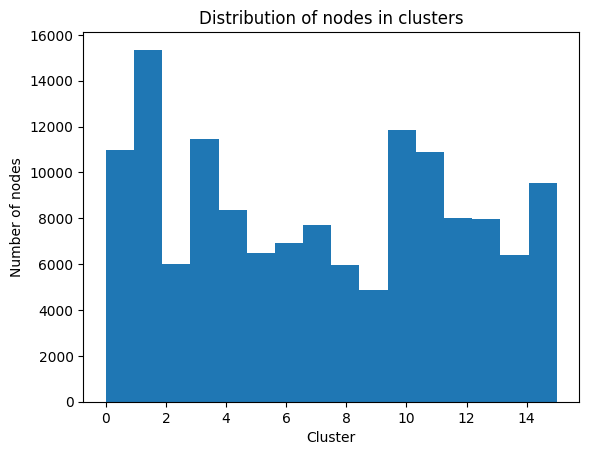

In [21]:
# draw a histogram of `cluster_assignments`
import matplotlib.pyplot as plt
plt.hist(cluster_assignments, bins=len(clusters))
plt.xlabel('Cluster')
plt.ylabel('Number of nodes')
plt.title('Distribution of nodes in clusters')
plt.show()

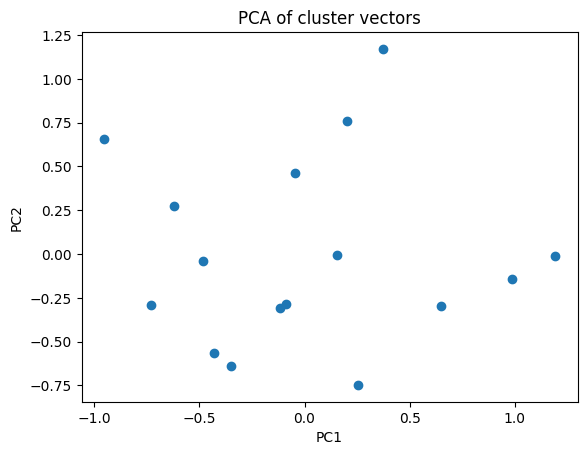

In [22]:
# load the cluster vectors from `U_posterior_mean.npy`
# run PCA on the cluster vectors
# plot the first two principal components
# color by cluster
# label by cluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

U_posterior_mean = np.load('U_left.npy')
pca = PCA(n_components=2)
pca.fit(U_posterior_mean)

U_pca = pca.transform(U_posterior_mean)

plt.scatter(U_pca[:, 0], U_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of cluster vectors')
plt.show()

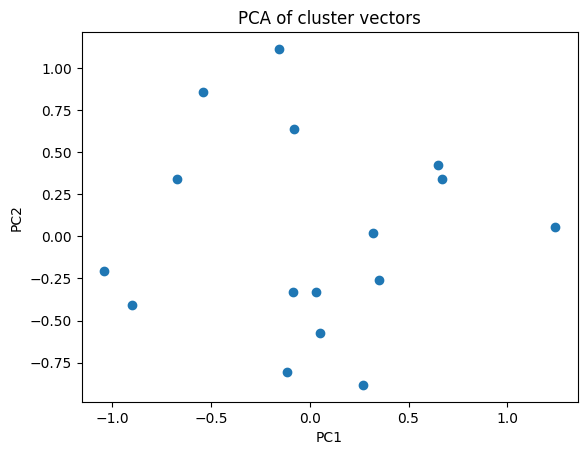

In [23]:
# load the cluster vectors from `U_posterior_mean.npy`
# run PCA on the cluster vectors
# plot the first two principal components
# color by cluster
# label by cluster

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

U_posterior_mean = np.load('U_right.npy')
pca = PCA(n_components=2)
pca.fit(U_posterior_mean)

U_pca = pca.transform(U_posterior_mean)

plt.scatter(U_pca[:, 0], U_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of cluster vectors')
plt.show()